# Combinatorial Symmetric Cross-Validation (CSCV) Analysis

This notebook demonstrates how to calculate the Probability of Backtest Overfitting (PBO)
using the Combinatorial Symmetric Cross-Validation method. We will test a set of
Moving Average Crossover strategies with different parameters to assess if the
process of selecting the "best" configuration is prone to overfitting.

In [6]:
import sys
import os
current_dir = os.getcwd()
# Navigate up one level to the project root (e.g., /path/to/my_project)
project_root = os.path.abspath(os.path.join(current_dir, '..'))
# Add the project root to sys.path so Python can find 'src' as a top-level package
if project_root not in sys.path:
    sys.path.append(project_root)


In [7]:
project_root

'/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final'

In [8]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# Assuming the script is run from the project root
from src.data_analysis.data_analysis import (
    fetch_historical_data,
    adjust_data_to_ubtc,
    sma,
)
from src.backtesting.backtesting import combinatorial_symmetric_cv

# Set plot style for better visualization
sns.set_style("whitegrid")

## 1. Define the Trading Strategy

We define a simple Moving Average (MA) Crossover strategy.
- A **long position** is opened when the short-term MA crosses above the long-term MA.
- A **short position** is opened when the short-term MA crosses below the long-term MA.
- Any existing position is closed before opening a new one in the opposite direction.
- A fixed percentage stop-loss is applied to all trades.

In [9]:
class MaCrossWithStopLoss(Strategy):
    """
    A simple Moving Average Crossover strategy with a fixed percentage stop-loss.
    """

    # Default parameters, will be overridden by the backtest run
    short_ma = 10
    long_ma = 50
    stop_loss_pct = 0.02

    def init(self):
        """Initialize the indicators."""
        price = self.data.Close
        self.ma1 = self.I(sma, price, self.short_ma)
        self.ma2 = self.I(sma, price, self.long_ma)

    def next(self):
        """Define the trading logic for the next tick."""
        price = self.data.Close[-1]

        # Long entry condition: bullish crossover
        if crossover(self.ma1, self.ma2):
            self.position.close()  # Close any existing short position
            stop_loss_price = price * (1 - self.stop_loss_pct)
            self.buy(sl=stop_loss_price)

        # Short entry condition: bearish crossover
        elif crossover(self.ma2, self.ma1):
            self.position.close()  # Close any existing long position
            stop_loss_price = price * (1 + self.stop_loss_pct)
            self.sell(sl=stop_loss_price)

## 2. Load Data and Define Strategy Configurations

We load historical BTC/USDT data and define the parameter grid for our MA Crossover strategy.
The parameters are based on the combinations requested:
- Short MA: 10, 20 days
- Long MA: 50, 100 days
- Stop-Loss: 1%, 2%

In [11]:
# Load data from a CSV file
# Ensure this path is correct relative to where you run the script
DATA_PATH = '/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/data/binance/python/data/spot/daily/klines/BTCUSDT/1h/BTCUSDT_consolidated_klines.csv'
START_DATE = "2022-01-01"
data = fetch_historical_data(data_path=DATA_PATH, start_date=START_DATE, timeframe="1d")
data = adjust_data_to_ubtc(data)
data.dropna(inplace=True)

print(f"Data loaded from {data.index.min()} to {data.index.max()}")

Data loaded from 2022-01-01 00:00:00 to 2025-11-07 23:00:00


In [12]:
# Define strategy parameter grid
param_grid = {
    "short_ma": [10, 20],
    "long_ma": [50, 100],
    "stop_loss_pct": [0.01, 0.02],
}

# Generate all valid combinations (where short_ma < long_ma)
all_params = list(itertools.product(*param_grid.values()))
strategy_configs = []
for params in all_params:
    config = dict(zip(param_grid.keys(), params))
    if config["short_ma"] < config["long_ma"]:
        strategy_configs.append(config)

print(f"\nGenerated {len(strategy_configs)} unique strategy configurations:")
for c in strategy_configs:
    print(c)


Generated 8 unique strategy configurations:
{'short_ma': 10, 'long_ma': 50, 'stop_loss_pct': 0.01}
{'short_ma': 10, 'long_ma': 50, 'stop_loss_pct': 0.02}
{'short_ma': 10, 'long_ma': 100, 'stop_loss_pct': 0.01}
{'short_ma': 10, 'long_ma': 100, 'stop_loss_pct': 0.02}
{'short_ma': 20, 'long_ma': 50, 'stop_loss_pct': 0.01}
{'short_ma': 20, 'long_ma': 50, 'stop_loss_pct': 0.02}
{'short_ma': 20, 'long_ma': 100, 'stop_loss_pct': 0.01}
{'short_ma': 20, 'long_ma': 100, 'stop_loss_pct': 0.02}


## 3. Run Backtests and Construct Performance Matrix

We now run a backtest for each strategy configuration. For each run, we extract the
daily returns from the equity curve. These return series are then combined into a
single DataFrame (the "performance matrix") required for the CSCV analysis.

In [13]:
all_returns = {}

for i, params in enumerate(strategy_configs):
    config_name = f"short_{params['short_ma']}_long_{params['long_ma']}_sl_{params['stop_loss_pct']}"
    print(f"Running backtest {i+1}/{len(strategy_configs)}: {config_name}")

    bt = Backtest(data, MaCrossWithStopLoss, cash=100_000, commission=0.001)
    stats = bt.run(**params)

    # Extract daily returns from the equity curve
    equity_curve = stats["_equity_curve"]["Equity"]
    daily_returns = equity_curve.pct_change().fillna(0)
    all_returns[config_name] = daily_returns

# Create the performance matrix from the collected returns
performance_matrix = pd.DataFrame(all_returns)
performance_matrix.dropna(inplace=True)

print("\nPerformance Matrix Head:")
print(performance_matrix.head())
print(f"\nMatrix Shape: {performance_matrix.shape}")

Running backtest 1/8: short_10_long_50_sl_0.01
Running backtest 2/8: short_10_long_50_sl_0.02
Running backtest 3/8: short_10_long_100_sl_0.01
Running backtest 4/8: short_10_long_100_sl_0.02
Running backtest 5/8: short_20_long_50_sl_0.01
Running backtest 6/8: short_20_long_50_sl_0.02
Running backtest 7/8: short_20_long_100_sl_0.01
Running backtest 8/8: short_20_long_100_sl_0.02

Performance Matrix Head:
                     short_10_long_50_sl_0.01  short_10_long_50_sl_0.02  \
timestamp                                                                 
2022-01-01 00:00:00                       0.0                       0.0   
2022-01-01 01:00:00                       0.0                       0.0   
2022-01-01 02:00:00                       0.0                       0.0   
2022-01-01 03:00:00                       0.0                       0.0   
2022-01-01 04:00:00                       0.0                       0.0   

                     short_10_long_100_sl_0.01  short_10_long_100_sl

## 4. Perform Combinatorial Symmetric Cross-Validation

With the performance matrix ready, we apply the `combinatorial_symmetric_cv` function
to calculate the Probability of Backtest Overfitting (PBO).

In [14]:
# Perform CSCV with S=16 splits
pbo, omega_values = combinatorial_symmetric_cv(performance_matrix, S=16)

print(f"\nProbability of Backtest Overfitting (PBO): {pbo:.4f}")

Running 12870 combinations for CSCV...
Processing combination 1000/12870...
Processing combination 2000/12870...
Processing combination 3000/12870...
Processing combination 4000/12870...
Processing combination 5000/12870...
Processing combination 6000/12870...
Processing combination 7000/12870...
Processing combination 8000/12870...
Processing combination 9000/12870...
Processing combination 10000/12870...
Processing combination 11000/12870...
Processing combination 12000/12870...

Probability of Backtest Overfitting (PBO): 0.8981


## 5. Analyze Results

A PBO value close to 1 suggests a high degree of overfitting, meaning the strategy
selection process is likely to choose a strategy that performs poorly out-of-sample.
A value close to 0 suggests the selection process is robust.

We visualize the distribution of the relative performance ranks (omega). If the distribution
is skewed towards values greater than 0.5, it indicates that the strategies selected as
best in-sample also tended to perform well out-of-sample.

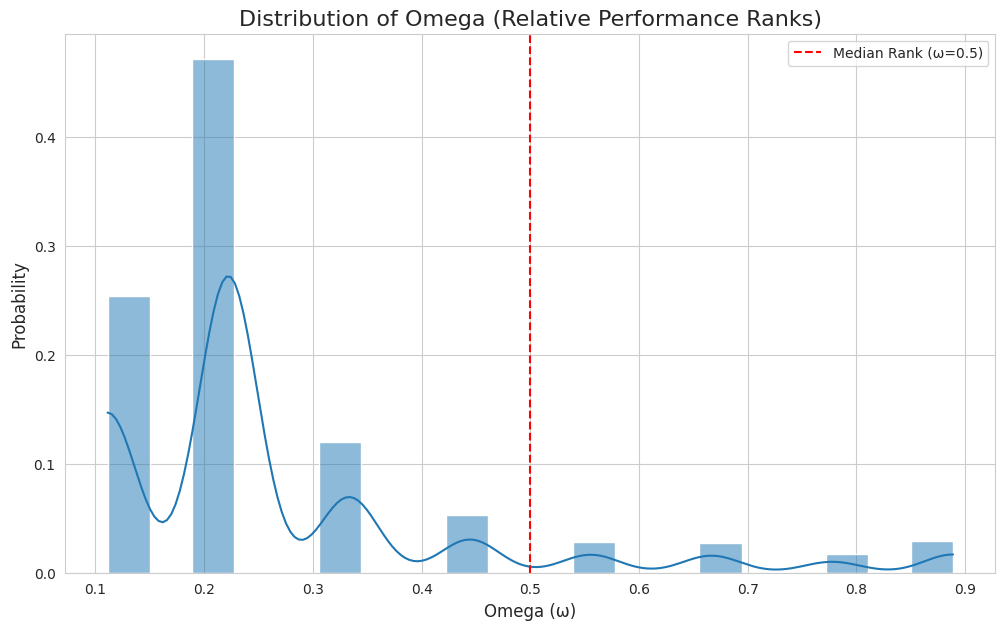

In [15]:
plt.figure(figsize=(12, 7))
sns.histplot(omega_values, bins=20, kde=True, stat="probability")
plt.axvline(
    0.5,
    color="red",
    linestyle="--",
    label="Median Rank (ω=0.5)",
)
plt.title("Distribution of Omega (Relative Performance Ranks)", fontsize=16)
plt.xlabel("Omega (ω)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.legend()
plt.show()